# Delivery Time Optimization

### The problem of optimizing the delivery time is similar to Multi-armed Bandit problem. 
________
### Wiki: In probability theory, the multi-armed bandit problem (sometimes called the K- or N-armed bandit problem) is a problem in which a gambler at a row of slot machines (sometimes known as "one-armed bandits") has to decide which machines to play, how many times to play each machine and in which order to play them. When played, each machine provides a random reward from a probability distribution specific to that machine. The objective of the gambler is to maximize the sum of rewards earned through a sequence of lever pulls.
------------

## What to look for?
### We will be looking for CTR - Click through Ratio. In order to calculate CTR we need to know how many emails were sent within an hour and how many clicks were performed within an hour as well. Example, from 14:00 - 14:59 there were 10 emails sent, 5 emails were clicked. Therefore CTR is 50%. 

-----------

## The optimum delivery time would be the time with highest CTR.
### Let's get technical:
_____

In [1]:
# import the packages
import pandas as pd
# First thing is to load the dataset
df = pd.read_csv('data.csv', low_memory = False)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(4)

,FirstName,LastName,LastOpen,hour,Time_Zone,lat,lng
0,3ae9d8799d1bb5e201e5704293bb54ef,1ba54f44556e8b14b4abca3dbd5dfcd0,2017-05-2022:50:46,2017-05-14 02:40:01,America/Vancouver,3b001cff9216f77d79fcdd34d19cc952,fae96e82b710d2632b15e07e02abeb5b
1,fc198cb6e0f97fc5d342bd029e77f29f,88a1c7790af92ba224315cabe0ea6829,2017-06-1517:16:36,2017-05-14 02:50:01,Asia/Manila,eb3e9af1d22acd8afb3d3b2d0f2de316,b4077ef95a489c7d513c5c96e859164f
2,3c25f89d5d1cd320ac8f27efb31e1438,501724f2a104cbac23f1cf549d582a8e,NaN,2017-05-14 02:55:01,Asia/Kolkata,263bdde363ea6155b853e8c70e7965f2,9bd63db17325e647a2391569941b3483
3,2964815d03a032c8ca37ac5d557647dd,3c31a642927cf90adfce8e94bc3ab80e,NaN,2017-05-14 03:00:03,America/New_York,5456f65988e9ee8394db57bea8393f4c,780b737d587890a076d0115f612f41f9


In [2]:
# we will be looking into DateAdded, and Last Open. If LastOpen is NaN, this means that email was not open at all
# we need to drop the dates, and leave only the time
# Now, in my opinion to make it easier, we should adjust the DateAdded to the range from 10:00 to 10:59
df['hour'] = df['hour'].str[10:]
df['hour'] = df['hour'].str[:3]
df.head(4)

,FirstName,LastName,LastOpen,hour,Time_Zone,lat,lng
0,3ae9d8799d1bb5e201e5704293bb54ef,1ba54f44556e8b14b4abca3dbd5dfcd0,2017-05-2022:50:46,02,America/Vancouver,3b001cff9216f77d79fcdd34d19cc952,fae96e82b710d2632b15e07e02abeb5b
1,fc198cb6e0f97fc5d342bd029e77f29f,88a1c7790af92ba224315cabe0ea6829,2017-06-1517:16:36,02,Asia/Manila,eb3e9af1d22acd8afb3d3b2d0f2de316,b4077ef95a489c7d513c5c96e859164f
2,3c25f89d5d1cd320ac8f27efb31e1438,501724f2a104cbac23f1cf549d582a8e,NaN,02,Asia/Kolkata,263bdde363ea6155b853e8c70e7965f2,9bd63db17325e647a2391569941b3483
3,2964815d03a032c8ca37ac5d557647dd,3c31a642927cf90adfce8e94bc3ab80e,NaN,03,America/New_York,5456f65988e9ee8394db57bea8393f4c,780b737d587890a076d0115f612f41f9


In [3]:
# Excellent
# now, last open can be changed into Boolean, since we don't really need to know when it was opened
# we just need to know wether they were opened/clicked or not.
df['Opened'] = pd.notnull(df['LastOpen'])
df.head(4)

,FirstName,LastName,LastOpen,hour,Time_Zone,lat,lng,Opened
0,3ae9d8799d1bb5e201e5704293bb54ef,1ba54f44556e8b14b4abca3dbd5dfcd0,2017-05-2022:50:46,02,America/Vancouver,3b001cff9216f77d79fcdd34d19cc952,fae96e82b710d2632b15e07e02abeb5b,True
1,fc198cb6e0f97fc5d342bd029e77f29f,88a1c7790af92ba224315cabe0ea6829,2017-06-1517:16:36,02,Asia/Manila,eb3e9af1d22acd8afb3d3b2d0f2de316,b4077ef95a489c7d513c5c96e859164f,True
2,3c25f89d5d1cd320ac8f27efb31e1438,501724f2a104cbac23f1cf549d582a8e,NaN,02,Asia/Kolkata,263bdde363ea6155b853e8c70e7965f2,9bd63db17325e647a2391569941b3483,False
3,2964815d03a032c8ca37ac5d557647dd,3c31a642927cf90adfce8e94bc3ab80e,NaN,03,America/New_York,5456f65988e9ee8394db57bea8393f4c,780b737d587890a076d0115f612f41f9,False


Noice. 
Makes life a bit easier, we dont really need the rest of the info, I want to keep the city and country in case we will want to adjust the tool for each time zone. However I have read that it is possible to make a general case for all time zones at once. 
Let's calculate the ratio, I want to do that by first counting number of emails for each HourSent

In [4]:
# the hours column can be optimized by making it catagorical
# also, you may want to correct hour extraction; df.hour[0]
df.hour = df.hour.astype('category')

In [5]:
# here is one way to build a mapping of hour to open ration
hour_ratio_lookup = {}
for hour in df.hour.unique():
    sdf = df[df.hour == hour]
    n_total_emails = len(sdf)
    n_opened_emails = sdf.Opened.sum()
    hour_ratio_lookup[hour] = n_opened_emails / n_total_emails

In [6]:
# printing the dictionary
print(hour_ratio_lookup)
ser = pd.Series(hour_ratio_lookup)
ndf = pd.DataFrame(columns=['hour', 'open_ratio'])
ndf.hour, ndf.open_ratio = ser.index, ser.values
# now let's apply the mapping and add the ratio column
df['open_ratio'] = df.hour.map(hour_ratio_lookup)

{' 02': 0.49470396523628463, ' 03': 0.5024898143956541, ' 04': 0.57051909892262487, ' 05': 0.63250049183553025, ' 06': 0.70409792442788721, ' 07': 0.72022684310018903, ' 08': 0.74280853696257343, ' 09': 0.82026527113597403, ' 10': 0.83757325060324028, ' 11': 0.85481784133469529, ' 12': 0.791296, ' 13': 0.66171003717472121, ' 14': 0.80939947780678856, ' 15': 0.86462217487253634, ' 16': 0.92475319594194982, ' 17': 0.91249034485892133, ' 18': 0.84664110114360058, ' 19': 0.80264146891442067, ' 20': 0.78920907418761499, ' 21': 0.81830508474576269, ' 22': 0.74678473539953616, ' 23': 0.72879942829919009, ' 00': 0.71167966957319873, ' 01': 0.5751272884844546}


In [7]:
ndf.head()

,hour,open_ratio
0,00,0.711680
1,01,0.575127
2,02,0.494704
3,03,0.502490
4,04,0.570519


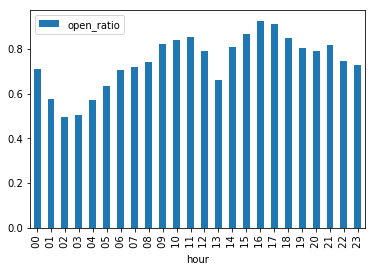

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

ndf.plot.bar(x='hour', y='open_ratio')

### Thanks to Rajan Khullar for help and Ravi Kiran Holur Vijay for his article